# TensorFlowのRNNのAPIを使わないRNNの実装

http://yusuke-ujitoko.hatenablog.com/entry/2018/02/28/191446

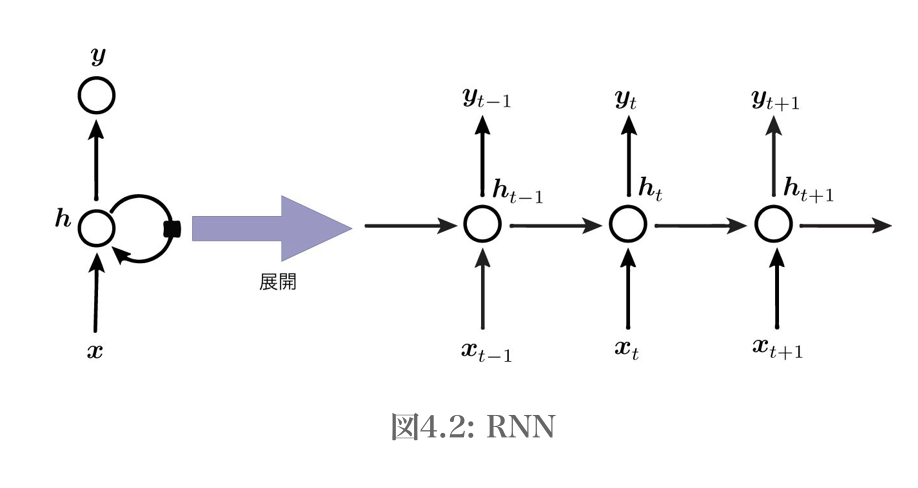

まずは2(タイム)ステップだけ動作するRNNをつくる。    
各ステップで入れるデータをX0, X1としてplaceholderをつくる。    
各ステップでは、入力ユニット数(=4)にあたるデータを用意。    
    
今回は隠れ層は1つとして、    
唯一の隠れ層のユニット数は6。    

In [0]:
import tensorflow as tf
import numpy as np
#セッション上の計算グラフをクリア
tf.reset_default_graph()

In [0]:
#インライン　テンソルボード
from IPython.display import clear_output, Image, display, HTML
import numpy as np

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [9]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

n_inputs = 4
n_neurons = 6
#X0が１ステップ目：例 t-1
#X1が２ステップ目：例 t
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

#1個目の入力層
#普通のパーセプトロンはここだけ。
Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
#１層目からの出力と2個目の入力から計算
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

# t = 0
X0_batch = np.array([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]])
# t = 1
X1_batch = np.array([[15, 14, 13, 12], [0, 0, 0, 0], [8, 7, 6, 5], [4, 3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_eval, Y1_eval = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    show_graph(tf.get_default_graph().as_graph_def()) # show graph

In [10]:
print(Y0_eval)
print(Y1_eval)

[[-0.9970508  -0.24527015 -0.9240224  -0.9999963   0.9894933  -0.99163723]
 [-0.99999005  0.9999994   0.9873505  -1.          0.99999994 -1.        ]
 [-0.99999994  1.          0.9999968  -1.          1.         -1.        ]
 [-1.          1.          1.         -1.          1.         -1.        ]]
[[-0.99999654  1.          1.         -1.          1.         -1.        ]
 [ 0.45630166 -0.8170688   0.01266436  0.9991603  -0.29044235 -0.48889416]
 [-0.9595501   1.          1.         -1.          1.         -1.        ]
 [ 0.7193978   0.99999785  0.9999804  -0.9998241   0.9980234  -0.99984175]]


# tf.contrib.rnn.static_rnn()を使う実装

上記実装はシンプルだが、
ステップ数を増やそうとするとネットワークが複雑になっていく。
そこでTensorFlowのstatic_rnnというAPIを使う。

static_rnnを使うと、TensorFlowで用意されたRNNのcellをrollingせずに記述できる。
cell(下ではBasicRNNCellを使用)というのは、各ステップに対応するRNNユニットと考えるとよい。

static_rnnで、それらのcellと各ステップの入力をAPI内で繋げてくれる。
具体的なstatic_rnnの内部の処理としては、
入力があるごとにcellをコピーして、上の実装のように繋げているようだ。


tf.contrib.rnn.static_rnnのアウトプット：    
output_seqs：出力の長さTのリスト（各入力に1つ）、またはそのような要素のネストされたタプル    
states：最終の状態    

In [11]:

tf.reset_default_graph()

n_inputs = 4
n_neurons = 6
#X0が１ステップ目
#X1が２ステップ目
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])
#各ステップに対応するRNNユニット
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#static_rnnで入力があるごとにcellをコピーして入力と繋げてくれる
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
#Y0, Y1の二つ出てくる
Y0, Y1 = output_seqs
init = tf.global_variables_initializer()

# t = 0
X0_batch = np.array([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]])
# t = 1
X1_batch = np.array([[15, 14, 13, 12], [0, 0, 0, 0], [8, 7, 6, 5], [4, 3, 2, 1]])

#Y0, Y1にそれぞれX0 X1を入れる
with tf.Session() as sess:
    init.run()
    Y0_eval, Y1_eval = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

print(Y0_eval)
print(Y1_eval)

[[-0.7666293   0.8937687  -0.08015542  0.7141229  -0.51377225 -0.09822006]
 [-0.02161411  0.99901694  0.4190035   0.97026455 -0.9628083  -0.98896   ]
 [ 0.7482053   0.99999136  0.7501478   0.9972723  -0.9977669  -0.99992496]
 [ 0.96104014  0.99999994  0.905167    0.9997529  -0.99986815 -0.99999946]]
[[ 0.99911994  0.99999875  0.94401526  0.9983082  -0.9998721  -1.        ]
 [-0.07760296 -0.126348   -0.8018254  -0.5509362  -0.52410203  0.4062834 ]
 [ 0.9978638   0.99867713 -0.22342187  0.61269563 -0.9969744  -0.99977463]
 [ 0.9886895   0.89448184 -0.6831732  -0.45687744 -0.9584544  -0.9699095 ]]


# 各ステップの入力をまとめて1つとして扱う

上の実装では、2ステップ分の入力のplaceholderをそれぞれX0, X1と定義していた。    
これもステップ数が多くなるとX0, X1, X2... と増やさないといけなくなるので、
入力をまとめて扱うようにする。    
    
具体的には、    
[バッチサイズ、ステップ数、入力ユニット数]としたplaceholderを用意してまとめて扱い、    
それらを各ステップの入力ごとにバラす    
(tf.unstackで1次元目に沿って、別々のリストに分ける）。    
    
出力のところでは逆にtf.stackを使って、    
各ステップでの出力結果を結合して、    
[バッチサイズ,ステップ数,出力ユニット数]を得ている。    



In [4]:
import tensorflow as tf

tf.reset_default_graph()

n_steps = 2
n_inputs = 4
n_neurons = 6

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))
#各ステップに対応するRNNユニット
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#static_rnnで入力があるごとにcellをコピーして入力と繋げてくれる
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()
#t=0が[0,1,2,3]〜[12, 13, 14, 15]
#t=1が[15, 14, 13, 12]〜[4, 3, 2, 1]
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2, 3], [15, 14, 13, 12]], 
        [[4, 5, 6, 7], [0, 0, 0, 0]], 
        [[8, 9, 10, 11], [8, 7, 6, 5]], 
        [[12, 13, 14, 15], [4, 3, 2, 1]], 
    ])
print(X_batch.shape)
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val)

(4, 2, 4)
[[[-0.50483656  0.630176    0.24019052  0.7141063  -0.2458259
    0.5988033 ]
  [-0.13636902 -0.99966013 -0.60905504 -0.97666806 -0.99995214
   -0.9990351 ]]

 [[-0.6138521  -0.20095237  0.23824127  0.5808502  -0.9331711
   -0.11094765]
  [-0.2188954   0.35705447  0.5502293  -0.07295222  0.26813704
   -0.51239014]]

 [[-0.7035941  -0.81747484  0.23629016  0.40697134 -0.99605954
   -0.7230902 ]
  [-0.07623591 -0.96363145  0.77151704 -0.86185706 -0.97618896
   -0.9944448 ]]

 [[-0.77538264 -0.97013533  0.23433708  0.1975739  -0.9997746
   -0.93747365]
  [ 0.08593705 -0.71956474  0.8613483  -0.7782344  -0.5778793
   -0.9716948 ]]]


# dynamic_rnnを使う

上の実装にはまだ問題がある。    
逆伝搬時の勾配計算のために、    
順伝搬時の各ステップの計算結果を保持して置く必要があるため、 メモリを圧迫してしまう。    
これを避けるためにstatic_rnnの代わりにdynamic_rnnを使うとよい。    
    
dynamic_rnnに渡す引数としてswap_memoryをTrueにしておけば、    
GPUからCPUにメモリ退避してくれる。    
    
また、別の利点として各ステップの入出力に、    
[バッチサイズ,ステップ数,ユニット数]をそのまま使えるので、    
上の実装にあるようにunstackやstackをしなくてよくなる。    

In [5]:
import tensorflow as tf

tf.reset_default_graph()

n_steps = 2
n_inputs = 4
n_neurons = 6

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#dynamic_rnnを使うと便利
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

#t=0が[0,1,2,3]〜[12, 13, 14, 15]
#t=1が[15, 14, 13, 12]〜[4, 3, 2, 1]
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2, 3], [15, 14, 13, 12]], 
        [[4, 5, 6, 7], [0, 0, 0, 0]], 
        [[8, 9, 10, 11], [8, 7, 6, 5]], 
        [[12, 13, 14, 15], [4, 3, 2, 1]], 
    ])
print(X_batch.shape)
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})
    
print(outputs_val)

(4, 2, 4)
[[[ 0.96722484  0.22145262 -0.0342239   0.98774487  0.94646037
    0.08623444]
  [ 1.         -0.9977444  -1.          1.          1.
    0.89609575]]

 [[ 0.99999285 -0.6322114  -0.99843556  0.99999994  0.9999934
    0.2447179 ]
  [-0.33936045  0.3658388  -0.64275503  0.5129521  -0.4292225
    0.69159496]]

 [[ 1.         -0.9373026  -0.9999987   1.          1.
    0.39112183]
  [ 0.99999255 -0.9424675  -0.99999964  1.          0.9999981
    0.7993714 ]]

 [[ 1.         -0.9907467  -1.          1.          1.
    0.5200883 ]
  [ 0.9699582  -0.6841372  -0.9995686   0.9995151   0.9859781
    0.7521945 ]]]


# ステップごとの入力を可変長とする

ここまでは各ステップでの入力長は固定だった。    
でも文字列みたいに可変長のステップを入れないといけない場合もある。    

そういう場合には、dynamic_rnnやstatic_rnnを呼ぶときに、sequence_lengthを設定する。    

In [11]:
import tensorflow as tf

tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 6

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

#可変長に
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

init = tf.global_variables_initializer()

#設定したsquence_lengthに満たない入力は0でpaddingして入力
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # 
        [[3, 4, 5], [0, 0, 0]], # 0でパディング
        [[6, 7, 8], [6, 5, 4]], # 
        [[9, 0, 1], [3, 2, 1]], # 
    ])
#可変長の設定
seq_length_batch = np.array([2, 1, 2, 2])

print(X_batch.shape)
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch, seq_length:seq_length_batch})
    
print(outputs_val)

(4, 2, 3)
[[[ 0.93984246 -0.42490202 -0.800023    0.83390534 -0.88221556
    0.7828828 ]
  [ 0.99999696 -0.99997574 -0.9999999   0.9999999  -0.9975161
    0.9996023 ]]

 [[ 0.99977696 -0.9876141  -0.9997148   0.9998153  -0.99169666
    0.99278057]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.9999992  -0.9998076  -0.99999964  0.9999998  -0.99944466
    0.99978447]
  [ 0.999535   -0.9990729  -0.9997452   0.99983174 -0.9869856
    0.99269605]]

 [[-0.83737296 -0.9122702  -0.99965996  0.9978028   0.9766567
    0.9632105 ]
  [ 0.9945458  -0.967904   -0.81282115  0.99194515 -0.98662084
    0.7078328 ]]]
